In [21]:
%%capture

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F

from torchtext.vocab import build_vocab_from_iterator
import nltk
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from bert_score import score as bert_score_fn
import matplotlib.pyplot as plt
import random
import re
from collections import Counter
from tqdm import tqdm
from tqdm.notebook import tqdm
import gdown
from functools import partial

import pickle
import numpy as np
import pandas as pd
import time
import os
import sys
import spacy
import ast

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

In [22]:

if torch.backends.mps.is_available():
    DEVICE = 'mps'  # Apple GPU 사용
elif torch.cuda.is_available():
    DEVICE = 'cuda'  # NVIDIA GPU 사용
else:
    DEVICE = 'cpu'   # CPU fallback

print(DEVICE)

cuda


In [23]:
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [24]:
# data 다운
train_path = 'Cooking_Dataset/train.csv'
dev_path = 'Cooking_Dataset/dev.csv'
test_path = 'Cooking_Dataset/test.csv'


if not os.path.exists('Cooking_Dataset'):
    os.makedirs('Cooking_Dataset')
    print("Downloading Dataset") 
    gdown.download("https://drive.google.com/uc?id=1uZdYjvllt0dSdKKtrCgKHUk-APKdmeNU", train_path, quiet=False)
    gdown.download("https://drive.google.com/uc?id=1SAMbkdtjGBYgojqobiwe7ZmnEq7SiGsF", dev_path, quiet=False)
    gdown.download("https://drive.google.com/uc?id=1v6Rr2et_4WA5mRwwlRxtLhn38pbmr9Yr", test_path, quiet=False)


train_df = pd.read_csv(train_path)
#train_df = train_df.sample(n=200,random_state=42)
dev_df = pd.read_csv(dev_path)
test_df = pd.read_csv(test_path)

# 데이터 확인
print(f"Train data size: {len(train_df)}")
print(f"Dev data size: {len(dev_df)}")
print(f"Test data size: {len(test_df)}")
print("\nTrain data sample:")
print(train_df.head())
#No-Bake Nut Cookies
# ["1 c. firmly packed brown sugar", "1/2 c. evaporated milk", "1/2 tsp. vanilla", "1/2 c. broken nuts (pecans)", "2 Tbsp. butter or margarine", "3 1/2 c. bite size shredded rice biscuits"]
# ["In a heavy 2-quart saucepan, mix brown sugar, nuts, evaporated milk and butter or margarine.", "Stir over medium heat until mixture bubbles all over top.", "Boil and stir 5 minutes more. Take off heat.", "Stir in vanilla and cereal; mix well.", "Using 2 teaspoons, drop and shape into 30 clusters on wax paper.", "Let stand until firm, about 30 minutes."]

Train data size: 162899
Dev data size: 1065
Test data size: 1081

Train data sample:
                      Title  \
0       No-Bake Nut Cookies   
1               Creamy Corn   
2      Reeses Cups(Candy)     
3  Cheeseburger Potato Soup   
4       Rhubarb Coffee Cake   

                                         Ingredients  \
0  ["1 c. firmly packed brown sugar", "1/2 c. eva...   
1  ["2 (16 oz.) pkg. frozen corn", "1 (8 oz.) pkg...   
2  ["1 c. peanut butter", "3/4 c. graham cracker ...   
3  ["6 baking potatoes", "1 lb. of extra lean gro...   
4  ["1 1/2 c. sugar", "1/2 c. butter", "1 egg", "...   

                                              Recipe  
0  ["In a heavy 2-quart saucepan, mix brown sugar...  
1  ["In a slow cooker, combine all ingredients. C...  
2  ["Combine first four ingredients and press in ...  
3  ["Wash potatoes; prick several times with a fo...  
4  ["Cream sugar and butter.", "Add egg and beat ...  


In [25]:
spacy_en = spacy.load('en_core_web_sm')

def tokenizer_ingredient_baseline(text):
    """
    Baseline 전처리: 소문자화 + lemmatization + 간단한 필터링
    - stopword 제거 있음
    - 숫자, 구두점 제거 있음
    - 불필요한 복잡 전처리 없음
    """
    import ast
    text_list = ast.literal_eval(text)
    tokens = []

    with spacy_en.select_pipes(disable=["parser", "ner", "tagger"]):
        for item in text_list:
            doc = spacy_en(item.lower())
            for token in doc:
                if token.is_punct or token.like_num or token.is_stop:
                    continue
                tokens.append(token.lemma_.strip())  # 기본 lemmatization만 유지
    return tokens



def tokenizer_recipe_baseline(text):
    """
    Recipe 전처리: 소문자화 + lemmatization만 수행 (구두점, stopword, 숫자는 유지)
    - 조리 순서, 동사 등 자연스러운 문장 흐름을 보존해야 하므로 간단한 전처리만 적용
    """
    tokens = []
    with spacy_en.select_pipes(disable=["parser", "ner", "tagger"]):
        doc = spacy_en(text.lower())
        for token in doc:
            # 너무 공격적인 필터링은 하지 않음
            if token.is_space:
                continue
            tokens.append(token.lemma_.strip())
    return tokens



def tokenizer_ingredient_checklist(text, remove_stopwords=True, lemmatize=True):
    text_list = ast.literal_eval(text)  # 문자열 → 리스트로 변환
    unit_keywords = {
        'c', 'cup', 'cups', 'tbsp', 'tablespoon', 'tsp', 'teaspoon',
        'oz', 'ounce', 'lb', 'pound', 'g', 'kg', 'mg',
        'pt', 'qt', 'gal', 'ml', 'l','carton','container',
        'package', 'pkg', 'envelope', 'box', 'bag', 'jar', 'can', 'cans', 'bottle',
        'dash', 'pinch', 'slice', 'slices', 'head', 'inch', 'inches',
        'stick', 'sticks', 'small', 'medium', 'large', 'size','graham'
    }

    tokens = []

    with spacy_en.select_pipes(disable=["parser", "ner"]):
        for item in text_list:
            doc = spacy_en(item.lower())
            for token in doc:
                if token.is_punct or token.is_space:
                    continue
                if token.like_num:
                    continue
                if token.text.strip(".") in unit_keywords:
                    continue
                if remove_stopwords and token.is_stop:
                    continue
                if token.pos_ in {"ADJ", "VERB", "ADV", "PRON"}:
                    continue

                tokens.append(token.lemma_.strip() if lemmatize else token.text.strip())
    

    return tokens

def tokenizer_recipe_extension(text):  # 디폴트: lemmatize 안 함
    text_list = ast.literal_eval(text)
    tokens = []

    # tagger는 유지해서 lemma 써도 warning 없음
    with spacy_en.select_pipes(disable=["parser", "ner", "tagger"]):
        for item in text_list:
            doc = spacy_en(item.lower())  # 소문자화
            for token in doc:
                if token.is_punct or token.is_space:
                    continue  # 마침표, 쉼표 제거
                if token.like_num:  # 숫자 유지
                    tokens.append(token.text.strip())
                    continue
                
                tokens.append(token.text.strip())
                
    return tokens




In [26]:
ing = train_df.iloc[1,2]
print(ing)
print(tokenizer_recipe_extension(ing))

["In a slow cooker, combine all ingredients. Cover and cook on low for 4 hours or until heated through and cheese is melted. Stir well before serving. Yields 6 servings."]
['in', 'a', 'slow', 'cooker', 'combine', 'all', 'ingredients', 'cover', 'and', 'cook', 'on', 'low', 'for', '4', 'hours', 'or', 'until', 'heated', 'through', 'and', 'cheese', 'is', 'melted', 'stir', 'well', 'before', 'serving', 'yields', '6', 'servings']


/home/psarda/repos/jkim0094-CookingRecipeGenerato/.venv/lib/python3.10/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [27]:
def build_vocab(token_lists, min_freq=2):
    # vocab 생성: 자주 등장하는 단어만 포함 + 특수 토큰 정의
    vocab = build_vocab_from_iterator(
        token_lists,  # 토큰 리스트들을 직접 반복
        min_freq=min_freq,  # 최소 등장 빈도
        specials=['<pad>', '<sos>', '<eos>', '<unk>']  # 특수 토큰 추가
    )
    vocab.set_default_index(vocab['<unk>'])  # 없는 단어는 <unk>로 처리
    return vocab

In [28]:
import os
import pickle
import requests
from tqdm import tqdm

def load_or_tokenize_data(model_type, train_df, config=None):
    use_checklist = config.get("USE_CHECKLIST", False)

    tokenizer_ingredient = tokenizer_ingredient_baseline
    tokenizer_recipe = tokenizer_recipe_baseline
    tokenizer_checklist = tokenizer_ingredient_checklist if use_checklist else None

    ingredient_cache_path = "tokens/ingredient_tokens.pkl"
    recipe_cache_path = "tokens/recipe_tokens.pkl"
    checklist_cache_path = "tokens/checklist_tokens.pkl"

    ingredient_cache_download = "https://drive.google.com/uc?id=1Wxvq-qy4ifbzPKmcm_VuNRRXrEOSqisJ"
    recipe_cache_download = "https://drive.google.com/uc?id=1IyBlDfL9sE8_Ip3muDyciCK9Hiv_VZF8"
    checklist_cache_download = "https://drive.google.com/uc?id=1-WVksjq8Cgj6UiJ7wtemU2CfP4hhPrci"

    if not os.path.exists('tokens'):
        os.makedirs('tokens')

    cache_targets = [
        (ingredient_cache_path, ingredient_cache_download),
        (recipe_cache_path, recipe_cache_download)
    ]
    if use_checklist:
        cache_targets.append((checklist_cache_path, checklist_cache_download))

    for path, url in cache_targets:
        if not os.path.exists(path):
            print(f"⬇️  Downloading: {path}")
            try:
                r = requests.get(url, allow_redirects=True)
                if r.status_code == 200:
                    with open(path, 'wb') as f:
                        f.write(r.content)
                    print(f"✅ Downloaded: {path}")
                else:
                    print(f"❌ Download failed for {path}")
            except Exception as e:
                print(f"❌ Download error: {e}")

    if os.path.exists(ingredient_cache_path):
        with open(ingredient_cache_path, "rb") as f:
            ingredient_token_lists = pickle.load(f)
        print("✅ Loaded ingredient token cache.")
    else:
        print("⚠️ No ingredient cache → Tokenizing...")
        ingredient_token_lists = [tokenizer_ingredient(text) for text in tqdm(train_df['Ingredients'], desc="Tokenizing ingredients")]
        with open(ingredient_cache_path, "wb") as f:
            pickle.dump(ingredient_token_lists, f)

    if os.path.exists(recipe_cache_path):
        with open(recipe_cache_path, "rb") as f:
            recipe_token_lists = pickle.load(f)
        print("✅ Loaded recipe token cache.")
    else:
        print("⚠️ No recipe cache → Tokenizing...")
        recipe_token_lists = [tokenizer_recipe(text) for text in tqdm(train_df['Recipe'], desc="Tokenizing recipes")]
        with open(recipe_cache_path, "wb") as f:
            pickle.dump(recipe_token_lists, f)

    ingredient_vocab = build_vocab(ingredient_token_lists, min_freq=1)
    recipe_vocab = build_vocab(recipe_token_lists, min_freq=2)

    checklist_vocab = None
    if use_checklist:
        if os.path.exists(checklist_cache_path):
            with open(checklist_cache_path, "rb") as f:
                checklist_token_lists = pickle.load(f)
            print("✅ Loaded checklist token cache.")
        else:
            print("⚠️ No checklist cache → Tokenizing...")
            checklist_token_lists = [tokenizer_checklist(text) for text in tqdm(train_df['Ingredients'], desc="Checklist tokenize")]
            with open(checklist_cache_path, "wb") as f:
                pickle.dump(checklist_token_lists, f)

        checklist_vocab = build_vocab(checklist_token_lists, min_freq=1)

    return ingredient_token_lists, recipe_token_lists, ingredient_vocab, recipe_vocab, tokenizer_ingredient, tokenizer_recipe, checklist_vocab, tokenizer_checklist




In [29]:
def get_checklist_tensor(checklist_vocab, checklist_tokenizer, ingredient_texts, device, embedding_layer):
    batch_ids = []



    for text in ingredient_texts:
        tokens = checklist_tokenizer(text)
        ids = [checklist_vocab[token] for token in tokens]
        batch_ids.append(torch.tensor(ids, dtype=torch.long))

    checklist_padded = pad_sequence(batch_ids, batch_first=True, padding_value=checklist_vocab['<pad>']).to(device)
    checklist_mask = (checklist_padded != checklist_vocab['<pad>']).float().to(device)
    checklist_embeds = embedding_layer(checklist_padded)



    return checklist_embeds, checklist_mask


In [30]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, df, ingredient_vocab, recipe_vocab, tokenizer_ingredient, tokenizer_recipe):
        self.df = df
        self.ingredient_vocab = ingredient_vocab
        self.recipe_vocab = recipe_vocab
        self.tokenizer_ingredient = tokenizer_ingredient
        self.tokenizer_recipe = tokenizer_recipe

    def __getitem__(self, idx):
        ingredient_text = self.df.iloc[idx]['Ingredients']
        recipe_text = self.df.iloc[idx]['Recipe']

        ingredient_tokens = self.tokenizer_ingredient(ingredient_text)
        recipe_tokens = self.tokenizer_recipe(recipe_text)

        ingredient_ids = [self.ingredient_vocab['<sos>']] + [self.ingredient_vocab[token] for token in ingredient_tokens] + [self.ingredient_vocab['<eos>']]
        recipe_ids = [self.recipe_vocab['<sos>']] + [self.recipe_vocab[token] for token in recipe_tokens] + [self.recipe_vocab['<eos>']]

        return torch.tensor(ingredient_ids), torch.tensor(recipe_ids), ingredient_text  # ✅ 3개 반환

    def __len__(self):
        return len(self.df)



In [31]:
def collate_fn(batch, ingredient_vocab, recipe_vocab, device):
    ingredients, recipes, ingredient_texts = zip(*batch)  # ingredient_texts: str
    ingredients_padded = pad_sequence(ingredients, batch_first=True, padding_value=ingredient_vocab['<pad>'])
    recipes_padded = pad_sequence(recipes, batch_first=True, padding_value=recipe_vocab['<pad>'])
    return ingredients_padded.to(device), recipes_padded.to(device), list(ingredient_texts)


In [32]:
class Encoder_GRU(nn.Module):
    def __init__(self, ingredient_vocab_size, embedding_dim, hidden_dim, n_layers, dropout_ratio,
                 embedding_weights=None, freeze=False):
        super().__init__()
        # 임베딩
        if embedding_weights is not None:
            self.embedding = nn.Embedding.from_pretrained(embedding_weights, freeze=freeze)
        else:
            self.embedding = nn.Embedding(ingredient_vocab_size, embedding_dim)
        

        # GRU 레이어
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.gru = nn.GRU(embedding_dim,
                          hidden_dim,
                          n_layers,
                          dropout=dropout_ratio if n_layers>1 else 0,
                          batch_first=True)

        # 드롭아웃
        self.dropout = nn.Dropout(dropout_ratio)

    def forward(self, src):
        # src : [batch_size, src_len]
        src = src.long() 
        # 임베딩
        embedded = self.dropout(self.embedding(src))
        # embedded : [batch_size, src_len, hidden_dim]

        # gru 통과
        outputs, hidden = self.gru(embedded) # h0를 따로 주지 않으면, 디폴트로 h0가 0로 초기화되서 들어감
        # outputs: [batch_size, src_len, hidden_size]
        # hidden: [n_layers, batch_size, hidden_size]

        return outputs,hidden

class Encoder_GRU_extension(nn.Module):
    def __init__(self, ingredient_vocab_size, embedding_dim, hidden_dim, n_layers, dropout_ratio,
                 embedding_weights=None, freeze=False):
        super().__init__()
        if embedding_weights is not None:
            self.embedding = nn.Embedding.from_pretrained(embedding_weights, freeze=freeze)
        else:
            self.embedding = nn.Embedding(ingredient_vocab_size, embedding_dim)
        self.ingredient_vocab_size = ingredient_vocab_size
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.dropout = nn.Dropout(dropout_ratio)

        self.gru = nn.GRU(embedding_dim, hidden_dim, n_layers,
                          dropout=dropout_ratio if n_layers > 1 else 0,
                          batch_first=True)

        self.skip_proj = nn.Linear(embedding_dim, hidden_dim)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)
        self.layer_norm = nn.LayerNorm(hidden_dim)

        self._init_weights()  # ✅ 초기화 적용

    def _init_weights(self):
        # embedding 초기화 (from_pretrained 아닌 경우만)
        if not hasattr(self.embedding, 'weight') or self.embedding.weight.requires_grad:
            nn.init.kaiming_normal_(self.embedding.weight, mode='fan_in', nonlinearity='leaky_relu')

        # GRU 내부 weight 초기화
        for name, param in self.gru.named_parameters():
            if 'weight' in name:
                nn.init.kaiming_normal_(param, mode='fan_in', nonlinearity='leaky_relu')
            elif 'bias' in name:
                nn.init.constant_(param, 0)

        # skip connection projection 초기화
        nn.init.kaiming_normal_(self.skip_proj.weight, mode='fan_in', nonlinearity='leaky_relu')
        nn.init.constant_(self.skip_proj.bias, 0)

    def forward(self, src):
        src = src.long()
        embedded = self.dropout(self.embedding(src))
        outputs, hidden = self.gru(embedded)
        skip = self.skip_proj(embedded)
        outputs = self.leaky_relu(outputs + skip)
        outputs = self.layer_norm(outputs)
        return outputs, hidden



class Decoder_GRU(nn.Module):
    def __init__(self, recipe_vocab_size, embedding_dim, hidden_dim, n_layers, dropout_ratio):
        super().__init__()

        self.recipe_vocab_size = recipe_vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.dropout_ratio = dropout_ratio

        # 임베딩
        self.embedding = nn.Embedding(recipe_vocab_size, embedding_dim)

        # GRU 레이어
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.gru = nn.GRU(embedding_dim,
                          hidden_dim,
                          n_layers,
                          dropout=dropout_ratio if n_layers>1 else 0,
                          batch_first=True)

        # fc 레이어
        self.fc_out = nn.Linear(hidden_dim, recipe_vocab_size)

        # 드롭아웃
        self.dropout = nn.Dropout(dropout_ratio)

    def forward(self, input, hidden):
        input = input.long()
        # input : [batch_size]
        input = input.unsqueeze(1)
        # input : [batch_size, 단어의 개수=1]

        # 임베딩
        embedded = self.dropout(self.embedding(input))
        # embedded : [batch_size, 단어의 개수=1, hidden_dim]

        # GRU 통과
        outputs, hidden = self.gru(embedded,hidden)
        # outputs: [batch_size, 단어의 개수=1, hidden_size]
        # hidden: [n_layers, batch_size, hidden_size]

        # fc 통과
        prediction = self.fc_out(outputs.squeeze(1))
        # prediction: [batch_size, vocab_size]

        return prediction, hidden

# Define a decoder with attention mechanism using PyTorch's nn.Module
class AttnDecoderRNN(nn.Module):
    def __init__(self, recipe_vocab_size,embedding_dim, hidden_size, n_layers, dropout_ratio):
        # Initialize the base nn.Module class
        super(AttnDecoderRNN, self).__init__()

        # Save parameters
        self.recipe_vocab_size = recipe_vocab_size              # Size of the output vocabulary
        self.embedding_dim = embedding_dim                  # Dropout probability
        self.hidden_size = hidden_size              # Size of the hidden state in GRU
        self.n_layers = n_layers
        self.dropout_ratio = dropout_ratio
                  

        # Define layers
        self.embedding = nn.Embedding(self.recipe_vocab_size, self.hidden_size)  # Converts word indices to dense vectors
        self.dropout = nn.Dropout(self.dropout_ratio)                          # Applies dropout for regularization
        self.gru = nn.GRU(self.hidden_size, self.hidden_size, self.n_layers, dropout=self.dropout_ratio if self.n_layers>1 else 0, batch_first=True)
             # GRU to process the embedded inputs
        self.out = nn.Linear(self.hidden_size * 2, self.recipe_vocab_size)       # Linear layer for generating final output

    def forward(self, input, hidden, encoder_outputs):
        input = input.long() 
        # input : [batch_size]
        input = input.unsqueeze(1)
        # input : [batch_size, 단어의 개수=1]

        # 임베딩
        embedded = self.dropout(self.embedding(input))
        # embedded : [batch_size, 단어의 개수=1, hidden_dim]

        # Pass through GRU
        output, hidden = self.gru(embedded, hidden)  # output: [batch, 1, hidden_size]

        # Compute attention weights using dot-product attention:
        # hidden[-1]: [batch, hidden_size]
        # encoder_outputs: [batch, src_len, hidden_size]
    
        attn_weights = F.softmax(
            torch.bmm(output, encoder_outputs.transpose(1, 2)), # [batch, 1, hidden_size] x [batch, hidden_size, src_len]
            dim=-1
        )  # [batch, 1, src_len]

        # Apply attention weights to encoder outputs to get context vector
        # attn_weights: (1, 1, max_length)
        # encoder_outputs.unsqueeze(0): (1, max_length, hidden_size)
        attn_output = torch.bmm(attn_weights, encoder_outputs)  # [batch, 1, hidden_size]

        # Concatenate attention output and decoder hidden state
        concat_output = torch.cat((output, attn_output), dim=2)  # [batch, 1, hidden*2]

        # Pass through linear layer and softmax to get output word probabilities
        output = F.log_softmax(self.out(concat_output).squeeze(1), dim=1)  # [batch, vocab_size]

        # Return output word distribution, updated hidden state, and attention weights
        return output, hidden, attn_weights.squeeze(1)

class AttnDecoderRNN_extension(nn.Module):
    def __init__(self, recipe_vocab_size, embedding_dim, hidden_size, n_layers, dropout_ratio):
        super().__init__()
        self.recipe_vocab_size = recipe_vocab_size
        self.embedding = nn.Embedding(recipe_vocab_size, embedding_dim)
        self.dropout = nn.Dropout(dropout_ratio)
        self.gru = nn.GRU(embedding_dim, hidden_size, n_layers,
                          dropout=dropout_ratio if n_layers > 1 else 0,
                          batch_first=True)
        self.out = nn.Linear(hidden_size * 2, recipe_vocab_size)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)
        self.layer_norm = nn.LayerNorm(hidden_size)

        self._init_weights()  # ✅ He 초기화 호출

    def _init_weights(self):
        # Embedding
        nn.init.kaiming_normal_(self.embedding.weight, mode='fan_in', nonlinearity='leaky_relu')

        # GRU weights & biases
        for name, param in self.gru.named_parameters():
            if 'weight' in name:
                nn.init.kaiming_normal_(param, mode='fan_in', nonlinearity='leaky_relu')
            elif 'bias' in name:
                nn.init.constant_(param, 0)

        # Linear layer
        nn.init.kaiming_normal_(self.out.weight, mode='fan_in', nonlinearity='leaky_relu')
        nn.init.constant_(self.out.bias, 0)

    def forward(self, input, hidden, encoder_outputs):
        input = input.long().unsqueeze(1)
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded, hidden)
        output = self.leaky_relu(output)
        output = self.layer_norm(output)

        attn_weights = F.softmax(torch.bmm(output, encoder_outputs.transpose(1, 2)), dim=-1)
        context = torch.bmm(attn_weights, encoder_outputs)
        concat_output = torch.cat((output, context), dim=2)
        output = F.log_softmax(self.out(concat_output).squeeze(1), dim=1)
        return output, hidden, attn_weights.squeeze(1)

class DecoderWithChecklist(nn.Module):
    def __init__(self, recipe_vocab_size, embedding_dim, hidden_size, n_layers, dropout_ratio, checklist_vocab_size, checklist_vocab, tokenizer_checklist):
        super().__init__()
        self.recipe_vocab_size = recipe_vocab_size
        self.embedding = nn.Embedding(recipe_vocab_size, embedding_dim)
        self.dropout = nn.Dropout(dropout_ratio)
        self.gru = nn.GRU(embedding_dim, hidden_size, n_layers,
                          dropout=dropout_ratio if n_layers > 1 else 0,
                          batch_first=True)

        self.checklist_embedding = nn.Embedding(checklist_vocab_size, hidden_size)
        self.attn_proj = nn.Linear(hidden_size, hidden_size)
        self.out_proj = nn.Linear(hidden_size, recipe_vocab_size)

        self.ref_selector = nn.Linear(hidden_size, 3)
        self.checklist_max_len = checklist_vocab_size
        self.checklist_vocab = checklist_vocab
        self.tokenizer_checklist = tokenizer_checklist
        self.a_prev_list = []

    def forward(self, input_token, hidden, encoder_outputs=None, ingredient_texts=None, a_prev=None, **kwargs):
        input_token = input_token.unsqueeze(1)
        embedded = self.dropout(self.embedding(input_token))
        gru_out, hidden = self.gru(embedded, hidden)
        h_t = gru_out.squeeze(1)

        if ingredient_texts is None or a_prev is None:
            output = self.out_proj(h_t)
            return output, hidden

        batch_ids = []
        for text in ingredient_texts:
            tokens = self.tokenizer_checklist(text)
            ids = [self.checklist_vocab[token] for token in tokens]
            batch_ids.append(torch.tensor(ids, dtype=torch.long))

        padded = pad_sequence(batch_ids, batch_first=True, padding_value=0)
        checklist_embeds = self.checklist_embedding(padded.to(input_token.device))
        checklist_mask = (padded != 0).float().to(input_token.device)

        used_mask = a_prev.clamp(0, 1).unsqueeze(2)
        unused_mask = (1 - a_prev).clamp(0, 1).unsqueeze(2)

        E_new = checklist_embeds * unused_mask
        E_used = checklist_embeds * used_mask

        h_proj = self.attn_proj(h_t).unsqueeze(2)
        scores_new = torch.bmm(E_new, h_proj).squeeze(2)
        scores_used = torch.bmm(E_used, h_proj).squeeze(2)

        scores_new = scores_new.masked_fill(checklist_mask == 0, -1e9)
        scores_used = scores_used.masked_fill(checklist_mask == 0, -1e9)

        alpha_new = F.softmax(scores_new, dim=1)
        alpha_used = F.softmax(scores_used, dim=1)

        c_new = torch.bmm(alpha_new.unsqueeze(1), checklist_embeds).squeeze(1)
        c_used = torch.bmm(alpha_used.unsqueeze(1), checklist_embeds).squeeze(1)

        f_logits = self.ref_selector(h_t)
        f = F.softmax(f_logits, dim=-1)
        f_gru, f_new, f_used = f.chunk(3, dim=1)

        o_t = f_gru * h_t + f_new * c_new + f_used * c_used
        output = self.out_proj(o_t)

        a_t = a_prev + f_new * alpha_new

        # ✅ Coverage Loss 계산을 위한 저장
        if self.training:
            if not hasattr(self, "a_prev_list"):
                self.a_prev_list = []
            self.a_prev_list.append((a_prev.detach(), alpha_new.detach()))

        return output, hidden, a_t, alpha_new, alpha_used





class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device, use_attention, recipe_vocab):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.use_attention = use_attention
        self.recipe_vocab = recipe_vocab  # 🔹 추가: vocab 저장

    def forward(self, src, ingredient_texts=None, target=None, teacher_forcing_ratio=0.5, max_len=50):
        encoder_outputs, hidden = self.encoder(src)
        batch_size = src.size(0)
        vocab_size = self.decoder.recipe_vocab_size

        checklist_embed, checklist_mask = None, None
        is_checklist_decoder = hasattr(self.decoder, 'checklist_vocab')

        if is_checklist_decoder:
            checklist_embed, checklist_mask = get_checklist_tensor(
                checklist_vocab=self.decoder.checklist_vocab,
                checklist_tokenizer=self.decoder.tokenizer_checklist,
                ingredient_texts=ingredient_texts,
                device=self.device,
                embedding_layer=self.decoder.checklist_embedding
            )

        a_prev = None
        if checklist_mask is not None:
            checklist_len = checklist_mask.size(1)
            a_prev = torch.zeros(batch_size, checklist_len, device=self.device)

        # ▶️ Inference mode
        if target is None:
            outputs = []
            input_token = torch.tensor([self.recipe_vocab['<sos>']] * batch_size).to(self.device).long()  # 🔹 수정

            for _ in range(max_len):
                if is_checklist_decoder:
                    output, hidden, a_prev, *_ = self.decoder(
                        input_token, hidden, encoder_outputs,
                        ingredient_texts=ingredient_texts, a_prev=a_prev,
                        checklist_embeds=checklist_embed,
                        checklist_mask=checklist_mask
                    )
                elif self.use_attention:
                    result = self.decoder(input_token, hidden, encoder_outputs)
                    output, hidden = result[:2] if isinstance(result, (tuple, list)) else result
                else:
                    output, hidden = self.decoder(input_token, hidden)

                top1 = output.argmax(1)
                outputs.append(top1.unsqueeze(1))
                input_token = top1

            return torch.cat(outputs, dim=1)

        # 🟢 Training mode
        target = target.long()
        target_len = target.shape[1]
        outputs = torch.zeros(batch_size, target_len, vocab_size).to(self.device)
        input_token = target[:, 0].long()

        for t in range(1, target_len):
            if is_checklist_decoder:
                output, hidden, a_prev, *_ = self.decoder(
                    input_token, hidden, encoder_outputs,
                    ingredient_texts=ingredient_texts, a_prev=a_prev,
                    checklist_embeds=checklist_embed,
                    checklist_mask=checklist_mask
                )
            elif self.use_attention:
                result = self.decoder(input_token, hidden, encoder_outputs)
                output, hidden = result[:2] if isinstance(result, (tuple, list)) else result
            else:
                output, hidden = self.decoder(input_token, hidden)

            outputs[:, t, :] = output
            top1 = output.argmax(1)
            teacher_force = torch.rand(1).item() < teacher_forcing_ratio
            input_token = target[:, t] if teacher_force else top1

        return outputs





class IngredientAutoEncoder(nn.Module):
    def __init__(self, encoder, decoder, vocab_size):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.vocab_size = vocab_size

    def forward(self, src):
        encoder_outputs, hidden = self.encoder(src)
        input_token = src[:, 0]  # <sos>
        outputs = torch.zeros(src.size(0), src.size(1) - 1, self.vocab_size).to(src.device)

        for t in range(1, src.size(1)):
            output, hidden, _ = self.decoder(input_token, hidden, encoder_outputs)
            outputs[:, t-1, :] = output
            input_token = src[:, t]  # teacher forcing

        return outputs




    



    



In [33]:
def build_glove_embedding_matrix(glove_path, vocab, glove_dim=200):
    print("🔎 Loading GloVe vectors...")
    glove_embeddings = {}

    with open(glove_path, 'r', encoding="utf-8") as f:
        for line in f:
            values = line.strip().split()
            word = values[0]
            vector = torch.tensor(list(map(float, values[1:])))
            glove_embeddings[word] = vector

    # Initialize matrix with random vectors
    embedding_matrix = torch.randn(len(vocab), glove_dim)

    for word, idx in vocab.get_stoi().items():
        if word in glove_embeddings:
            embedding_matrix[idx] = glove_embeddings[word]

    print("✅ GloVe embedding matrix created.")
    return embedding_matrix


In [34]:
def loss_epoch(model, dataloader, criterion, optimizer=None,
               teacher_forcing_ratio=0.5, max_len=50,
               USE_PENALTY=False, penalty_lambda=0.2):
    # model.train() if optimizer else model.eval()
    total_loss = 0
    batch_losses = []
    # ✅ attention checklist decoder의 coverage 정보 초기화
    if hasattr(model.decoder, "a_prev_list"):
        model.decoder.a_prev_list = []

    for i, (src_batch, trg_batch, ingredient_texts) in enumerate(dataloader):
        src_batch = src_batch.to(DEVICE)
        trg_batch = trg_batch.to(DEVICE)

        output = model(src_batch, ingredient_texts, trg_batch,
                       teacher_forcing_ratio=teacher_forcing_ratio,
                       max_len=max_len)

        output_dim = output.shape[-1]
        output = output[:, 1:, :].reshape(-1, output_dim)
        trg = trg_batch[:, 1:].reshape(-1)

        # ✅ 기본 cross entropy loss
        loss = criterion(output, trg)

        # ✅ Penalty Loss 추가 (조건부)
        if USE_PENALTY and hasattr(model.decoder, 'a_prev_list'):
            penalty = 0.0
            for a_prev, alpha_new in model.decoder.a_prev_list:
                penalty += torch.sum(torch.min(a_prev, alpha_new))
            penalty = penalty / src_batch.size(0)  # 평균화
            loss += penalty_lambda * penalty

        if optimizer is not None:
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
            optimizer.step()

        batch_loss = loss.item() * src_batch.shape[0]
        batch_losses.append(batch_loss)
        total_loss += batch_loss
        print(f"Batch {i+1}/{len(dataloader)} | Loss: {loss.item():.4f}")

    epoch_loss = total_loss / len(dataloader.dataset)
    return epoch_loss, batch_losses





def Train(model, train_loader, val_loader, criterion, optimizer,recipe_vocab,
          EPOCHS, BATCH_SIZE, TRAIN_RATIO,
          save_model_path, save_history_path, TEACHER_FORCING_RATIO, MAX_LEN, **kwargs
          ):
    """
    이어서 학습할 수 있게 start_epoch와 best_val_loss를 인자로 받음
    """
    lr_step = kwargs.get("LR_STEP")
    lr_gamma = kwargs.get("LR_GAMMA")

    if isinstance(lr_step, int) and isinstance(lr_gamma, float):
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=lr_step, gamma=lr_gamma)
    else:
        scheduler = None
    # if "LR_STEP" in kwargs:
    #     scheduler = StepLR(optimizer, step_size = kwargs["LR_STEP"], gamma = kwargs["LR_GAMMA"])
    # else:
    #     scheduler = None

    
    loss_history = {"train_epoch": [], "train_iter": [], "val_epoch": []}
    best_val_loss = float('inf')
    train_start_time = time.time()
    best_epoch = -1
    best_train_loss = None
    
    #for ep in tqdm(range(EPOCHS), desc="Epochs",file=sys.stdout):
    for ep in range(EPOCHS):

        ep_start_time = time.time()
        current_lr = optimizer.param_groups[0]["lr"]
        print(f"[Epoch: {ep+1}/{EPOCHS}] current_LR = {current_lr}")

        # Training
        model.train()
        train_epoch_loss, train_batch_loss = loss_epoch(
            model, train_loader, criterion, optimizer,
            teacher_forcing_ratio=TEACHER_FORCING_RATIO,
            max_len=MAX_LEN,
            USE_PENALTY=config.get("USE_PENALTY", False),
            penalty_lambda=config.get("PENALTY_LAMBDA", 0.2)
        )
        loss_history["train_epoch"].append(train_epoch_loss)
        loss_history["train_iter"].append(train_batch_loss)
        print(f"{ep+1} Epoch Train Completed!")
    
        

        # Validation
        print("Validation Start!")
        model.eval()
        with torch.no_grad():
            val_loss, _ = loss_epoch(
                model, val_loader, criterion, optimizer=None,
                teacher_forcing_ratio=0.0,
                max_len=MAX_LEN,
                USE_PENALTY=config.get("USE_PENALTY", False),
                penalty_lambda=config.get("PENALTY_LAMBDA", 0.2)
            )
            loss_history["val_epoch"].append(val_loss)
        print("Validation Completed!")

        ep_elapsed_time = time.time() - ep_start_time
        print("-" * 50)
        print(f"[Epoch {ep+1}/{EPOCHS}] ")
        print(f"Train Loss: {train_epoch_loss:.4f} | Val Loss: {val_loss:.4f} | Time: {ep_elapsed_time:.2f}s")
        bleu, meteor, bert_f1 = compute_metrics(model, val_loader, recipe_vocab, max_len=MAX_LEN)
        print(f"Validation Metrics:")
        print(f"📊 BLEU: {bleu:.4f} | METEOR: {meteor:.4f} | BERTScore-F1: {bert_f1:.4f}")  
        print("-" * 50) 

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = ep+1
            best_train_loss = train_epoch_loss
            best_bleu, best_meteor, best_bert_f1 = bleu, meteor, bert_f1
            # 디렉토리 없으면 생성
            os.makedirs("results", exist_ok=True)
            torch.save({
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "epoch": ep+1,
                "val_loss": val_loss,
                "train_loss": train_epoch_loss,  # train_loss 저장
            }, save_model_path)
            print("Best model saved!")

        if scheduler is not None:
            scheduler.step()
    # 🔸 Save final model after training
    final_model_path = save_model_path.replace(".pt", "_final.pt")
    torch.save({
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "epoch": EPOCHS,
        "val_loss": val_loss,
        "train_loss": train_epoch_loss,
    }, final_model_path)
    print("Final model saved!")
    
    
    # Save training history
    train_elapsed_time = time.time() - train_start_time
    total_iterations = sum(len(batch_list) for batch_list in loss_history["train_iter"])
    torch.save({
        "loss_history": loss_history,
        "EPOCHS": EPOCHS,
        "BATCH_SIZE": BATCH_SIZE,   
        "TRAIN_RATIO": TRAIN_RATIO,
        "train_elapsed_time": train_elapsed_time,
        "total_iterations": total_iterations,
        "LR_STEP": kwargs["LR_STEP"] if "LR_STEP" in kwargs else None,
        "LR_GAMMA": kwargs["LR_GAMMA"] if "LR_GAMMA" in kwargs else None
    }, save_history_path)
    print("Training Completed!")
    print(f"Total number of iteration : {total_iterations}")
    print(f"Total Time for Training: {train_elapsed_time:.2f}s")
    # Summary print
    print("\n======= Training Summary =======")
    print(f"Best Model:    Epoch {best_epoch}")
    if best_epoch == EPOCHS:
        print(f"(Best model is the final model)")
    print(f"Train Loss:    {best_train_loss:.4f}")
    print(f"Val Loss:      {best_val_loss:.4f}")
    print(f"BLEU:          {best_bleu:.4f}")
    print(f"METEOR:        {best_meteor:.4f}")
    print(f"BERTScore-F1:  {best_bert_f1:.4f}")
    print("\n")
    print(f"Final Model:   Epoch {EPOCHS}")
    print(f"Train Loss:    {train_epoch_loss:.4f}")
    print(f"Val Loss:      {val_loss:.4f}")
    print(f"BLEU:          {bleu:.4f}")
    print(f"METEOR:        {meteor:.4f}")
    print(f"BERTScore-F1:  {bert_f1:.4f}")
    print(f"Total Time:     {train_elapsed_time:.2f}s")
    print("==================================\n")
    return loss_history

def train_autoencoder(model, dataloader, criterion, optimizer, epochs, device, label="AutoEncoder"):
    model.train()
    for ep in range(epochs):
        total_loss = 0
        for src_batch, _ in dataloader:
            src_batch = src_batch.to(device)
            output = model(src_batch)
            trg = src_batch[:, 1:].contiguous()

            output = output.view(-1, output.size(-1))
            trg = trg.view(-1)

            loss = criterion(output, trg)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f"[Epoch {ep+1}] {label} Loss: {avg_loss:.4f}")



def Test(model, test_loader, criterion, recipe_vocab, MAX_LEN):
    model.eval()

    with torch.no_grad():
        test_loss, _ = loss_epoch(model, test_loader, criterion, optimizer=None, teacher_forcing_ratio=0.0, max_len=MAX_LEN)

    # 평가 지표 계산
    bleu_score, meteor_avg, bertscore_f1 = compute_metrics(model, test_loader, recipe_vocab)

    print(f"Test Loss      : {test_loss:.4f}")
    print(f"BLEU-4 Score   : {bleu_score:.4f}")
    print(f"METEOR Score   : {meteor_avg:.4f}")
    print(f"BERTScore (F1) : {bertscore_f1:.4f}")

    return test_loss, bleu_score, meteor_avg, bertscore_f1



def compute_metrics(model, dataloader, recipe_vocab, max_len=50):
    """
    테스트셋 전체에서 BLEU, METEOR, BERTScore 계산

    Returns:
        bleu_score (float), meteor_avg (float), bertscore_f1 (float)
    """
    model.eval()
    smoothie = SmoothingFunction().method4

    ref_list = []
    hyp_list = []

    with torch.no_grad():
        for src_batch, trg_batch, ingredient_texts in tqdm(dataloader, desc="Evaluating Metrics"):

            src_batch = src_batch.to(DEVICE)
            trg_batch = trg_batch.to(DEVICE)

            generated = model(src_batch, target=None, teacher_forcing_ratio=0.0, max_len=max_len)

            for i in range(src_batch.size(0)):
                pred_tokens = generated[i].tolist()
                trg_tokens = trg_batch[i].tolist()

                # <eos> 기준으로 자르기
                if recipe_vocab['<eos>'] in pred_tokens:
                    pred_tokens = pred_tokens[:pred_tokens.index(recipe_vocab['<eos>'])]
                if recipe_vocab['<eos>'] in trg_tokens:
                    trg_tokens = trg_tokens[:trg_tokens.index(recipe_vocab['<eos>'])]

                pred_words = [recipe_vocab.get_itos()[idx] for idx in pred_tokens]
                trg_words = [recipe_vocab.get_itos()[idx] for idx in trg_tokens]

                ref_list.append(trg_words)
                hyp_list.append(pred_words)

    # BLEU-4
    bleu_score = corpus_bleu([[ref] for ref in ref_list], hyp_list, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie) 

    # METEOR
    meteor_scores = [meteor_score([ref], hyp) for ref, hyp in zip(ref_list, hyp_list)]
    meteor_avg = sum(meteor_scores) / len(meteor_scores)

    # BERTScore
    refs = [" ".join(ref) for ref in ref_list]
    hyps = [" ".join(hyp) for hyp in hyp_list]
    _, _, f1 = bert_score_fn(hyps, refs, lang='en', verbose=False)
    bertscore_f1 = f1.mean().item()

    return bleu_score, meteor_avg, bertscore_f1


def plot_loss_epoch(name, loss_history):
    plt.figure(figsize=(6, 3))

    train_loss = loss_history["train_epoch"]
    val_loss = loss_history["val_epoch"]

    plt.plot(range(1, len(train_loss) + 1), train_loss, label="Train Loss", color="blue")
    plt.plot(range(1, len(val_loss) + 1), val_loss, label="Validation Loss", color="red")

    plt.xlabel("Epoch", fontsize=10)
    plt.ylabel("Loss", fontsize=10)
    plt.title(f"Loss per Epoch: {name}", fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_loss_iter(**models_histories):
    plt.figure(figsize=(10, 6))
    for model_name, history in models_histories.items():
        train_iter_losses = history.get("train_iter", [])
        if train_iter_losses:
            flat_iter_losses = [loss for epoch_losses in train_iter_losses for loss in epoch_losses]
            plt.plot(flat_iter_losses, label=model_name)
        else:
            print(f"[경고] {model_name}에 train_iter 데이터가 없습니다.")

    plt.title("Training Iteration Loss")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [35]:
def get_encoder_decoder(model_type, config, input_dim, output_dim, embedding_weights=None, freeze_embedding=False, checklist_vocab=None, tokenizer_checklist=None):
    use_attention = config["USE_ATTENTION"]
    is_extension = "extension" in model_type

    if is_extension:
        encoder = Encoder_GRU_extension(
            ingredient_vocab_size=input_dim,
            embedding_dim=config["EMBED_DIM"],
            hidden_dim=config["HIDDEN_DIM"],
            n_layers=config["N_LAYERS"],
            dropout_ratio=config["DROPOUT"],
            embedding_weights=embedding_weights,
            freeze=freeze_embedding
        )
        if config.get("USE_CHECKLIST", False):
            decoder = DecoderWithChecklist(
                recipe_vocab_size=output_dim,
                embedding_dim=config["EMBED_DIM"],
                hidden_size=config["HIDDEN_DIM"],
                n_layers=config["N_LAYERS"],
                dropout_ratio=config["DROPOUT"],
                checklist_vocab_size=len(checklist_vocab),
                checklist_vocab=checklist_vocab,
                tokenizer_checklist=tokenizer_checklist
            )
        else:
            decoder = AttnDecoderRNN_extension(
                recipe_vocab_size=output_dim,
                embedding_dim=config["EMBED_DIM"],
                hidden_size=config["HIDDEN_DIM"],
                n_layers=config["N_LAYERS"],
                dropout_ratio=config["DROPOUT"]
            )
    else:
        encoder = Encoder_GRU(
            ingredient_vocab_size=input_dim,
            embedding_dim=config["EMBED_DIM"],
            hidden_dim=config["HIDDEN_DIM"],
            n_layers=config["N_LAYERS"],
            dropout_ratio=config["DROPOUT"],
            embedding_weights=embedding_weights,
            freeze=freeze_embedding
        )
        if use_attention:
            decoder = AttnDecoderRNN(
                recipe_vocab_size=output_dim,
                embedding_dim=config["EMBED_DIM"],
                hidden_size=config["HIDDEN_DIM"],
                n_layers=config["N_LAYERS"],
                dropout_ratio=config["DROPOUT"]
            )
        else:
            decoder = Decoder_GRU(
                recipe_vocab_size=output_dim,
                embedding_dim=config["EMBED_DIM"],
                hidden_dim=config["HIDDEN_DIM"],
                n_layers=config["N_LAYERS"],
                dropout_ratio=config["DROPOUT"]
            )

    return encoder, decoder


def MakingAutoEncoder(model_type, config, ingredient_vocab, train_loader, embedding_weights=None, freeze_embedding=False):

    os.makedirs("results", exist_ok=True)

    INPUT_DIM = len(ingredient_vocab)

    # 3. Encoder/Decoder 구성 (output_dim = input_dim)
    encoder, decoder = get_encoder_decoder(
        model_type=model_type,
        config=config,
        input_dim=INPUT_DIM,
        output_dim=INPUT_DIM,
        embedding_weights=embedding_weights,
        freeze_embedding=freeze_embedding
    )

    # 4. AutoEncoder 모델 생성
    autoencoder = IngredientAutoEncoder(encoder, decoder, vocab_size=INPUT_DIM).to(DEVICE)

    optimizer = torch.optim.Adam(autoencoder.parameters(), lr=config.get("LR", 0.001))
    criterion = nn.CrossEntropyLoss(ignore_index=ingredient_vocab['<pad>'])

    # 5. 학습
    print(f"🚀 Pretraining AutoEncoder for {model_type}")
    train_autoencoder(
        model=autoencoder,
        dataloader=train_loader,
        criterion=criterion,
        optimizer=optimizer,
        epochs=config.get("AUTOENCODER_EPOCHS", 10),
        device=DEVICE
    )

    # 6. 가중치 저장
    encoder_path = f"results/{model_type}_encoder_pretrained.pt"
    decoder_path = f"results/{model_type}_decoder_pretrained.pt"
    torch.save(encoder.state_dict(), encoder_path)
    torch.save(decoder.state_dict(), decoder_path)

    print(f"✅ Saved pretrained encoder to: {encoder_path}")
    print(f"✅ Saved pretrained decoder to: {decoder_path}")

def main(model_type: str, config: dict,
         train_df, dev_df, test_df,
         glove_path: str = "./glove.6B.200d.txt"):

    # 1. Tokenize & Vocab
    ingredient_token_lists, recipe_token_lists, ingredient_vocab, recipe_vocab, tokenizer_ingredient, tokenizer_recipe, checklist_vocab, tokenizer_checklist = load_or_tokenize_data(model_type, train_df, config)

    # 2. GloVe 임베딩 적용 여부
    embedding_weights = None
    freeze_embedding = config.get("freeze_embedding", False)
    if config.get("use_glove", False):
        print(f"🔎 Using GloVe embeddings for {model_type}")
        ingredient_embedding_matrix = build_glove_embedding_matrix(
            glove_path, ingredient_vocab, glove_dim=config["EMBED_DIM"]
        )
        embedding_weights = ingredient_embedding_matrix

    # 3. Dataset & DataLoader
    BATCH_SIZE = config.get("BATCH_SIZE", 64)
    train_dataset = CustomDataset(train_df, ingredient_vocab, recipe_vocab, tokenizer_ingredient, tokenizer_recipe)
    dev_dataset = CustomDataset(dev_df, ingredient_vocab, recipe_vocab, tokenizer_ingredient, tokenizer_recipe)
    test_dataset = CustomDataset(test_df, ingredient_vocab, recipe_vocab, tokenizer_ingredient, tokenizer_recipe)
    collate = partial(collate_fn, ingredient_vocab=ingredient_vocab, recipe_vocab=recipe_vocab, device=DEVICE)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate)
    dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate)

    # ✅ 4. AutoEncoder 사전학습 여부에 따라 사전학습 실행 (ingredient_vocab 사용)
    if config.get("USE_AUTOENCODER", False):
        print(f"📦 AutoEncoder pretraining required for {model_type}")
        MakingAutoEncoder(
            model_type=model_type,
            config=config,
            input_vocab=ingredient_vocab,
            train_loader=train_loader,
            embedding_weights=embedding_weights,
            freeze_embedding=freeze_embedding,
            device=DEVICE
        )

    # 5. Model 구성 (recipe_vocab 사용)
    INPUT_DIM = len(ingredient_vocab)
    OUTPUT_DIM = len(recipe_vocab)
    criterion = nn.CrossEntropyLoss(ignore_index=recipe_vocab['<pad>'])

    encoder, decoder = get_encoder_decoder(
        model_type=model_type,
        config=config,
        input_dim=INPUT_DIM,
        output_dim=OUTPUT_DIM,
        embedding_weights=embedding_weights,
        freeze_embedding=freeze_embedding,
        checklist_vocab=checklist_vocab,
        tokenizer_checklist=tokenizer_checklist
    )

    # ✅ 6. 사전학습된 AutoEncoder 인코더 가중치만 로드
    if config.get("USE_AUTOENCODER", False):
        encoder_path = f"results/{model_type}_encoder_pretrained.pt"
        print(f"🔁 Loading pretrained AutoEncoder encoder weights for {model_type}")
        encoder.load_state_dict(torch.load(encoder_path, map_location=DEVICE))

    model = Seq2Seq(encoder, decoder, DEVICE, use_attention=config["USE_ATTENTION"],recipe_vocab=recipe_vocab).to(DEVICE)

    # 7. 학습 또는 로드
    save_model_path = f"results/{model_type}.pt"
    save_history_path = f"results/{model_type}_history.pt"

    if config["new_model_train"]:
        print(f"Training model: {model_type}")
        print(model)
        optimizer = optim.Adam(model.parameters(), lr=config["LR"])
        loss_history = Train(
            model=model,
            train_loader=train_loader,
            val_loader=dev_loader,
            criterion=criterion,
            optimizer=optimizer,
            recipe_vocab=recipe_vocab,
            EPOCHS=config["EPOCHS"],
            BATCH_SIZE=BATCH_SIZE,
            TRAIN_RATIO=1.0,
            save_model_path=save_model_path,
            save_history_path=save_history_path,
            TEACHER_FORCING_RATIO=config["TEACHER_FORCING_RATIO"],
            MAX_LEN=config["MAX_LEN"],
            LR_STEP=config.get("LR_STEP"),
            LR_GAMMA=config.get("LR_GAMMA")
        )
        return model, encoder, decoder, loss_history, save_model_path, save_history_path, test_loader, recipe_vocab, ingredient_vocab

    else:
        return model, encoder, decoder, None, save_model_path, save_history_path, test_loader, recipe_vocab, ingredient_vocab




In [36]:
# 하이퍼파라미터 저장
experiment_configs = {
    "baseline1": {
        "new_model_train" : True,
        "EMBED_DIM": 128,
        "HIDDEN_DIM": 256,
        "DROPOUT": 0.5,
        "N_LAYERS": 1,
        "LR": 0.001,
        "EPOCHS": 5,
        "USE_ATTENTION": False,
        "TEACHER_FORCING_RATIO": 0.5,
        "MAX_LEN": 50,
        "BATCH_SIZE": 64
    },
    "baseline2": {
        "new_model_train" : True,
        "EMBED_DIM": 128,
        "HIDDEN_DIM": 256,
        "DROPOUT": 0.5,
        "N_LAYERS": 1,
        "LR": 0.001,
        "EPOCHS": 5,
        "USE_ATTENTION": True,
        "TEACHER_FORCING_RATIO": 0.5,
        "MAX_LEN": 50,
        "BATCH_SIZE": 64
    }#,
    # "mild_extension1": {
    #     "new_model_train" : True,
    #     "EMBED_DIM": 256,
    #     "HIDDEN_DIM": 512,
    #     "DROPOUT": 0.5,
    #     "N_LAYERS": 3,
    #     "LR": 0.001,
    #     "EPOCHS": 5,
    #     "USE_ATTENTION": True,
    #     "TEACHER_FORCING_RATIO": 0.5,
    #     "MAX_LEN": 100,
    #     "LR_STEP": 1,         
    #     "LR_GAMMA": 0.7,
    #     "BATCH_SIZE": 64
    # },
    # "mild_extension2": {
    #     "new_model_train" : True,
    #     "EMBED_DIM": 200,  # GloVe 6B 200D와 일치
    #     "HIDDEN_DIM": 512,
    #     "DROPOUT": 0.5,
    #     "N_LAYERS": 2,
    #     "LR": 0.001,
    #     "EPOCHS": 5,
    #     "USE_ATTENTION": True,
    #     "TEACHER_FORCING_RATIO": 0.5,
    #     "MAX_LEN": 100,
    #     "LR_STEP": 1,         
    #     "LR_GAMMA": 0.7,
    #     "use_glove": True,   
    #     "freeze_embedding": False,
    #     "BATCH_SIZE": 64,
    #     "USE_AUTOENCODER": True,
    #     "AUTOENCODER_EPOCHS": 10,
    # },
    # "spicy_extension1": {
    #     "new_model_train": True,
    #     "EMBED_DIM": 256,
    #     "HIDDEN_DIM": 512,
    #     "DROPOUT": 0.5,
    #     "N_LAYERS": 2,
    #     "LR": 0.001,
    #     "EPOCHS": 10,
    #     "USE_ATTENTION": True,
    #     "TEACHER_FORCING_RATIO": 0.5,
    #     "MAX_LEN": 100,
    #     "LR_STEP": 1,         
    #     "LR_GAMMA": 0.7,
    #     "BATCH_SIZE": 64,
    #     "USE_CHECKLIST": True
    #}
}

In [37]:
def MakingAutoEncoder(model_type, config, input_vocab, train_loader,
                      embedding_weights=None, freeze_embedding=False,device=DEVICE):

    os.makedirs("results", exist_ok=True)

    INPUT_DIM = len(input_vocab)

    # 1. Encoder / Decoder 준비 (입력 = 출력)
    encoder, decoder = get_encoder_decoder(
        model_type=model_type,
        config=config,
        input_dim=INPUT_DIM,
        output_dim=INPUT_DIM,
        embedding_weights=embedding_weights,
        freeze_embedding=freeze_embedding
    )

    # 2. AutoEncoder 구성
    autoencoder = IngredientAutoEncoder(encoder, decoder, vocab_size=INPUT_DIM).to(device)
    optimizer = torch.optim.Adam(autoencoder.parameters(), lr=config.get("LR", 0.001))
    criterion = nn.CrossEntropyLoss(ignore_index=input_vocab['<pad>'])

    # 3. 학습
    print(f"🚀 Pretraining AutoEncoder for {model_type}")
    train_autoencoder(autoencoder, train_loader, criterion, optimizer,
                      epochs=config.get("EPOCHS", 5), device=device)

    # 4. 저장
    torch.save(encoder.state_dict(), f"results/{model_type}_encoder_pretrained.pt")
    torch.save(decoder.state_dict(), f"results/{model_type}_decoder_pretrained.pt")
    print(f"✅ Saved pretrained encoder/decoder for {model_type}")


In [38]:
def load_trained_model(model_type: str, config: dict, device=DEVICE):
    """
    best model과 final model을 모두 불러옵니다.

    Args:
        model_type (str): 저장 파일 이름 결정에 사용되는 모델 이름
        config (dict): 설정 정보 (input_dim, output_dim, attention 등 포함)
        device (torch.device): 모델을 로드할 디바이스

    Returns:
        best_model (nn.Module)
        final_model (nn.Module)
        loss_history (dict)
        best_checkpoint (dict)
        final_checkpoint (dict)
    """
    # 경로 구성
    best_model_path = f"results/{model_type}.pt"
    final_model_path = best_model_path.replace(".pt", "_final.pt")
    save_history_path = f"results/{model_type}_history.pt"

    # 모델 구조 재생성 (encoder/decoder 두 번 생성)
    INPUT_DIM = config["input_dim"]
    OUTPUT_DIM = config["output_dim"]

    def build_model():
        encoder, decoder = get_encoder_decoder(
            model_type=model_type,
            config=config,
            input_dim=INPUT_DIM,
            output_dim=OUTPUT_DIM,
            embedding_weights=None,
            freeze_embedding=config.get("freeze_embedding", False),
            checklist_vocab=None,
            tokenizer_checklist=None
        )
        return Seq2Seq(encoder, decoder, device, use_attention=config["USE_ATTENTION"], recipe_vocab=config["recipe_vocab"]).to(device)

    # ✅ Best model
    best_model = build_model()
    best_checkpoint = torch.load(best_model_path, map_location=device)
    best_model.load_state_dict(best_checkpoint["model_state_dict"])

    # ✅ Final model
    final_model = build_model()
    final_checkpoint = torch.load(final_model_path, map_location=device)
    final_model.load_state_dict(final_checkpoint["model_state_dict"])

    # ✅ 학습 이력
    history = torch.load(save_history_path, map_location=device)
    loss_history = history["loss_history"]

    print(f"📥 Loaded BEST model (Epoch {best_checkpoint['epoch']})")
    print(f"📥 Loaded FINAL model (Epoch {final_checkpoint['epoch']})")

    return best_model, final_model, loss_history, best_checkpoint, final_checkpoint


In [39]:
def summarize_and_test_model(model_type: str,
                             config: dict,
                             ingredient_vocab,
                             recipe_vocab,
                             test_loader,
                             criterion,
                             device=DEVICE):
    """
    저장된 best/final 모델을 불러와 summary, 그래프, 테스트 수행
    """

    # config에 input/output dim 추가 (원본 손상 X)
    config = config.copy()
    config["input_dim"] = len(ingredient_vocab)
    config["output_dim"] = len(recipe_vocab)

    # 모델 두 개 모두 불러오기
    best_model, final_model, loss_history, best_ckpt, final_ckpt = load_trained_model(model_type, config, device)

    # ✅ 손실 곡선 시각화
    plot_loss_epoch(model_type, loss_history)

    # ✅ BEST 모델 평가
    print(f"\n========== BEST MODEL SUMMARY ({model_type}) ==========")
    print(f"Epoch:         {best_ckpt['epoch']}")
    print(f"Train Loss:    {best_ckpt['train_loss']:.4f}")
    print(f"Val Loss:      {best_ckpt['val_loss']:.4f}")
    print(f"Parameters:    {sum(p.numel() for p in best_model.parameters() if p.requires_grad):,}")

    print("\nRunning test on BEST model...")
    best_test_loss, best_bleu, best_meteor, best_bert = Test(
        best_model, test_loader, criterion, recipe_vocab, MAX_LEN=config["MAX_LEN"]
    )

    print("\n--- BEST MODEL TEST RESULTS ---")
    print(f"Test Loss    : {best_test_loss:.4f}")
    print(f"BLEU-4 Score : {best_bleu:.4f}")
    print(f"METEOR Score : {best_meteor:.4f}")
    print(f"BERTScore-F1 : {best_bert:.4f}")
    print("-" * 50)

    # ✅ FINAL 모델 평가
    print(f"\n========== FINAL MODEL SUMMARY ({model_type}) ==========")
    print(f"Epoch:         {final_ckpt['epoch']}")
    print(f"Train Loss:    {final_ckpt['train_loss']:.4f}")
    print(f"Val Loss:      {final_ckpt['val_loss']:.4f}")
    print(f"Parameters:    {sum(p.numel() for p in final_model.parameters() if p.requires_grad):,}")

    print("\nRunning test on FINAL model...")
    final_test_loss, final_bleu, final_meteor, final_bert = Test(
        final_model, test_loader, criterion, recipe_vocab, MAX_LEN=config["MAX_LEN"]
    )

    print("\n--- FINAL MODEL TEST RESULTS ---")
    print(f"Test Loss    : {final_test_loss:.4f}")
    print(f"BLEU-4 Score : {final_bleu:.4f}")
    print(f"METEOR Score : {final_meteor:.4f}")
    print(f"BERTScore-F1 : {final_bert:.4f}")
    print("-" * 50)


    # ✅ 결과 리턴 (딕셔너리로)
    return {
        "best": {
            "test_loss": best_test_loss,
            "BLEU": best_bleu,
            "METEOR": best_meteor,
            "BERTScore": best_bert,
        },
        "final": {
            "test_loss": final_test_loss,
            "BLEU": final_bleu,
            "METEOR": final_meteor,
            "BERTScore": final_bert,
        }
    }



================== 🔧 Training & Evaluating: baseline1 ==================
⬇️  Downloading: tokens/ingredient_tokens.pkl
✅ Downloaded: tokens/ingredient_tokens.pkl
⬇️  Downloading: tokens/recipe_tokens.pkl
✅ Downloaded: tokens/recipe_tokens.pkl
✅ Loaded ingredient token cache.
✅ Loaded recipe token cache.
Training model: baseline1
Seq2Seq(
  (encoder): Encoder_GRU(
    (embedding): Embedding(9032, 128)
    (gru): GRU(128, 256, batch_first=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder_GRU(
    (embedding): Embedding(9081, 128)
    (gru): GRU(128, 256, batch_first=True)
    (fc_out): Linear(in_features=256, out_features=9081, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (recipe_vocab): Vocab()
)
[Epoch: 1/5] current_LR = 0.001
Batch 1/2546 | Loss: 9.1386
Batch 2/2546 | Loss: 9.0656
Batch 3/2546 | Loss: 8.9915
Batch 4/2546 | Loss: 8.8856
Batch 5/2546 | Loss: 8.7206
Batch 6/2546 | Loss: 8.4906
Batch 7/2546 | Loss: 8.2248
Batch 8/2546 | Loss: 7.

Evaluating Metrics: 100%|██████████| 17/17 [01:39<00:00,  5.84s/it]


Validation Metrics:
📊 BLEU: 0.1318 | METEOR: 0.2727 | BERTScore-F1: 0.8494
--------------------------------------------------
Best model saved!
[Epoch: 2/5] current_LR = 0.001
Batch 1/2546 | Loss: 3.6235
Batch 2/2546 | Loss: 3.2827
Batch 3/2546 | Loss: 3.4178
Batch 4/2546 | Loss: 3.5648
Batch 5/2546 | Loss: 3.4401
Batch 6/2546 | Loss: 3.6805
Batch 7/2546 | Loss: 3.5452
Batch 8/2546 | Loss: 3.2667
Batch 9/2546 | Loss: 3.6434
Batch 10/2546 | Loss: 3.5376
Batch 11/2546 | Loss: 3.4317
Batch 12/2546 | Loss: 3.1924
Batch 13/2546 | Loss: 3.6048
Batch 14/2546 | Loss: 3.4975
Batch 15/2546 | Loss: 3.1520
Batch 16/2546 | Loss: 3.3735
Batch 17/2546 | Loss: 3.1402
Batch 18/2546 | Loss: 3.5049
Batch 19/2546 | Loss: 3.6729
Batch 20/2546 | Loss: 3.7234
Batch 21/2546 | Loss: 3.4269
Batch 22/2546 | Loss: 3.2838
Batch 23/2546 | Loss: 3.2767
Batch 24/2546 | Loss: 3.2612
Batch 25/2546 | Loss: 3.4090
Batch 26/2546 | Loss: 3.4551
Batch 27/2546 | Loss: 3.3543
Batch 28/2546 | Loss: 3.0428
Batch 29/2546 | Loss:

Evaluating Metrics: 100%|██████████| 17/17 [01:43<00:00,  6.07s/it]


Validation Metrics:
📊 BLEU: 0.1343 | METEOR: 0.2853 | BERTScore-F1: 0.8592
--------------------------------------------------
[Epoch: 3/5] current_LR = 0.001
Batch 1/2546 | Loss: 3.3616
Batch 2/2546 | Loss: 3.1084
Batch 3/2546 | Loss: 3.2132
Batch 4/2546 | Loss: 3.5204
Batch 5/2546 | Loss: 3.3827
Batch 6/2546 | Loss: 3.0801
Batch 7/2546 | Loss: 3.3823
Batch 8/2546 | Loss: 3.3115
Batch 9/2546 | Loss: 3.1087
Batch 10/2546 | Loss: 2.9809
Batch 11/2546 | Loss: 3.2622
Batch 12/2546 | Loss: 3.2148
Batch 13/2546 | Loss: 3.5506
Batch 14/2546 | Loss: 3.4010
Batch 15/2546 | Loss: 3.5041
Batch 16/2546 | Loss: 3.1056
Batch 17/2546 | Loss: 3.1152
Batch 18/2546 | Loss: 3.2969
Batch 19/2546 | Loss: 3.5219
Batch 20/2546 | Loss: 3.0847
Batch 21/2546 | Loss: 3.3022
Batch 22/2546 | Loss: 3.3986
Batch 23/2546 | Loss: 3.2613
Batch 24/2546 | Loss: 3.0275
Batch 25/2546 | Loss: 3.3368
Batch 26/2546 | Loss: 3.1243
Batch 27/2546 | Loss: 3.2412
Batch 28/2546 | Loss: 3.3405
Batch 29/2546 | Loss: 3.7385
Batch 30/2

Evaluating Metrics: 100%|██████████| 17/17 [01:45<00:00,  6.19s/it]


Validation Metrics:
📊 BLEU: 0.1441 | METEOR: 0.2919 | BERTScore-F1: 0.8611
--------------------------------------------------
[Epoch: 4/5] current_LR = 0.001
Batch 1/2546 | Loss: 3.1391
Batch 2/2546 | Loss: 3.0107
Batch 3/2546 | Loss: 3.2041
Batch 4/2546 | Loss: 3.4353
Batch 5/2546 | Loss: 3.1190
Batch 6/2546 | Loss: 3.2469
Batch 7/2546 | Loss: 3.0627
Batch 8/2546 | Loss: 3.1593
Batch 9/2546 | Loss: 3.2212
Batch 10/2546 | Loss: 3.4589
Batch 11/2546 | Loss: 3.0827
Batch 12/2546 | Loss: 2.9279
Batch 13/2546 | Loss: 3.3141
Batch 14/2546 | Loss: 3.4590
Batch 15/2546 | Loss: 3.0076
Batch 16/2546 | Loss: 3.1756
Batch 17/2546 | Loss: 3.2874
Batch 18/2546 | Loss: 2.9442
Batch 19/2546 | Loss: 3.3645
Batch 20/2546 | Loss: 3.1498
Batch 21/2546 | Loss: 3.1370
Batch 22/2546 | Loss: 2.9235
Batch 23/2546 | Loss: 3.2147
Batch 24/2546 | Loss: 3.2818
Batch 25/2546 | Loss: 3.0803
Batch 26/2546 | Loss: 3.1583
Batch 27/2546 | Loss: 2.9895
Batch 28/2546 | Loss: 3.1676
Batch 29/2546 | Loss: 3.1899
Batch 30/2

Evaluating Metrics: 100%|██████████| 17/17 [01:47<00:00,  6.32s/it]


Validation Metrics:
📊 BLEU: 0.1380 | METEOR: 0.2814 | BERTScore-F1: 0.8554
--------------------------------------------------
Best model saved!
[Epoch: 5/5] current_LR = 0.001
Batch 1/2546 | Loss: 3.3337
Batch 2/2546 | Loss: 3.2260
Batch 3/2546 | Loss: 3.1608
Batch 4/2546 | Loss: 3.0582
Batch 5/2546 | Loss: 3.1911
Batch 6/2546 | Loss: 3.1190
Batch 7/2546 | Loss: 3.3366
Batch 8/2546 | Loss: 3.1951
Batch 9/2546 | Loss: 3.2222
Batch 10/2546 | Loss: 3.0577
Batch 11/2546 | Loss: 3.0666
Batch 12/2546 | Loss: 3.0414
Batch 13/2546 | Loss: 3.5070
Batch 14/2546 | Loss: 3.1717
Batch 15/2546 | Loss: 3.3184
Batch 16/2546 | Loss: 3.0074
Batch 17/2546 | Loss: 3.2579
Batch 18/2546 | Loss: 3.0363
Batch 19/2546 | Loss: 3.0401
Batch 20/2546 | Loss: 3.0040
Batch 21/2546 | Loss: 3.4552
Batch 22/2546 | Loss: 3.1313
Batch 23/2546 | Loss: 3.3755
Batch 24/2546 | Loss: 3.4163
Batch 25/2546 | Loss: 3.4130
Batch 26/2546 | Loss: 3.0532
Batch 27/2546 | Loss: 3.0453
Batch 28/2546 | Loss: 2.8752
Batch 29/2546 | Loss:

Evaluating Metrics: 100%|██████████| 17/17 [01:47<00:00,  6.35s/it]


Validation Metrics:
📊 BLEU: 0.1557 | METEOR: 0.3020 | BERTScore-F1: 0.8612
--------------------------------------------------
Final model saved!
Training Completed!
Total number of iteration : 12730
Total Time for Training: 15812.74s

======= Training Summary =======
Best Model:    Epoch 4
Train Loss:    3.1972
Val Loss:      5.0492
BLEU:          0.1380
METEOR:        0.2814
BERTScore-F1:  0.8554


Final Model:   Epoch 5
Train Loss:    3.1555
Val Loss:      5.1398
BLEU:          0.1557
METEOR:        0.3020
BERTScore-F1:  0.8612
Total Time:     15812.74s

📥 Loaded BEST model (Epoch 4)
📥 Loaded FINAL model (Epoch 5)


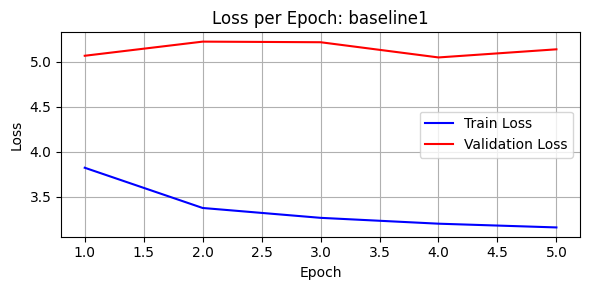


========== BEST MODEL SUMMARY (baseline1) ==========
Epoch:         4
Train Loss:    3.1972
Val Loss:      5.0492
Parameters:    5,245,177

Running test on BEST model...
Batch 1/17 | Loss: 5.0934
Batch 2/17 | Loss: 4.9155
Batch 3/17 | Loss: 4.9100
Batch 4/17 | Loss: 5.0473
Batch 5/17 | Loss: 4.9401
Batch 6/17 | Loss: 4.8990
Batch 7/17 | Loss: 4.9240
Batch 8/17 | Loss: 5.0995
Batch 9/17 | Loss: 4.9471
Batch 10/17 | Loss: 5.0064
Batch 11/17 | Loss: 5.1301
Batch 12/17 | Loss: 4.9714
Batch 13/17 | Loss: 5.1873
Batch 14/17 | Loss: 4.9149
Batch 15/17 | Loss: 5.1937
Batch 16/17 | Loss: 5.0994
Batch 17/17 | Loss: 5.1979


Evaluating Metrics: 100%|██████████| 17/17 [01:35<00:00,  5.63s/it]


Test Loss      : 5.0270
BLEU-4 Score   : 0.1391
METEOR Score   : 0.2816
BERTScore (F1) : 0.8555

--- BEST MODEL TEST RESULTS ---
Test Loss    : 5.0270
BLEU-4 Score : 0.1391
METEOR Score : 0.2816
BERTScore-F1 : 0.8555
--------------------------------------------------

========== FINAL MODEL SUMMARY (baseline1) ==========
Epoch:         5
Train Loss:    3.1555
Val Loss:      5.1398
Parameters:    5,245,177

Running test on FINAL model...
Batch 1/17 | Loss: 5.1869
Batch 2/17 | Loss: 5.0914
Batch 3/17 | Loss: 4.9758
Batch 4/17 | Loss: 5.2149
Batch 5/17 | Loss: 5.0539
Batch 6/17 | Loss: 4.9949
Batch 7/17 | Loss: 5.0616
Batch 8/17 | Loss: 5.2070
Batch 9/17 | Loss: 4.9836
Batch 10/17 | Loss: 5.0812
Batch 11/17 | Loss: 5.2314
Batch 12/17 | Loss: 5.1235
Batch 13/17 | Loss: 5.1818
Batch 14/17 | Loss: 5.0011
Batch 15/17 | Loss: 5.2299
Batch 16/17 | Loss: 5.1709
Batch 17/17 | Loss: 5.2633


Evaluating Metrics: 100%|██████████| 17/17 [01:36<00:00,  5.67s/it]


Test Loss      : 5.1199
BLEU-4 Score   : 0.1560
METEOR Score   : 0.3013
BERTScore (F1) : 0.8621

--- FINAL MODEL TEST RESULTS ---
Test Loss    : 5.1199
BLEU-4 Score : 0.1560
METEOR Score : 0.3013
BERTScore-F1 : 0.8621
--------------------------------------------------

================== 🔧 Training & Evaluating: baseline2 ==================
✅ Loaded ingredient token cache.
✅ Loaded recipe token cache.
Training model: baseline2
Seq2Seq(
  (encoder): Encoder_GRU(
    (embedding): Embedding(9032, 128)
    (gru): GRU(128, 256, batch_first=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): AttnDecoderRNN(
    (embedding): Embedding(9081, 256)
    (dropout): Dropout(p=0.5, inplace=False)
    (gru): GRU(256, 256, batch_first=True)
    (out): Linear(in_features=512, out_features=9081, bias=True)
  )
  (recipe_vocab): Vocab()
)
[Epoch: 1/5] current_LR = 0.001
Batch 1/2546 | Loss: 9.1291
Batch 2/2546 | Loss: 8.9326
Batch 3/2546 | Loss: 8.4908
Batch 4/2546 | Loss: 8.1560
Batch 5/

Evaluating Metrics: 100%|██████████| 17/17 [01:41<00:00,  5.99s/it]


Validation Metrics:
📊 BLEU: 0.1556 | METEOR: 0.2962 | BERTScore-F1: 0.8622
--------------------------------------------------
Best model saved!
[Epoch: 2/5] current_LR = 0.001
Batch 1/2546 | Loss: 3.3145
Batch 2/2546 | Loss: 3.1925
Batch 3/2546 | Loss: 3.2662
Batch 4/2546 | Loss: 3.2205
Batch 5/2546 | Loss: 3.1084
Batch 6/2546 | Loss: 3.2805
Batch 7/2546 | Loss: 3.2846
Batch 8/2546 | Loss: 3.5235
Batch 9/2546 | Loss: 3.4772
Batch 10/2546 | Loss: 3.2322
Batch 11/2546 | Loss: 3.1470
Batch 12/2546 | Loss: 3.3961
Batch 13/2546 | Loss: 3.4313
Batch 14/2546 | Loss: 3.4600
Batch 15/2546 | Loss: 3.2516
Batch 16/2546 | Loss: 3.2340
Batch 17/2546 | Loss: 3.1295
Batch 18/2546 | Loss: 3.4887
Batch 19/2546 | Loss: 3.0073
Batch 20/2546 | Loss: 3.2491
Batch 21/2546 | Loss: 3.2631
Batch 22/2546 | Loss: 3.0167
Batch 23/2546 | Loss: 3.2199
Batch 24/2546 | Loss: 3.3277
Batch 25/2546 | Loss: 3.2902
Batch 26/2546 | Loss: 3.0533
Batch 27/2546 | Loss: 3.3633
Batch 28/2546 | Loss: 3.2936
Batch 29/2546 | Loss:

Evaluating Metrics: 100%|██████████| 17/17 [01:42<00:00,  6.05s/it]


Validation Metrics:
📊 BLEU: 0.1587 | METEOR: 0.3069 | BERTScore-F1: 0.8656
--------------------------------------------------
Best model saved!
[Epoch: 3/5] current_LR = 0.001
Batch 1/2546 | Loss: 3.1275
Batch 2/2546 | Loss: 3.0215
Batch 3/2546 | Loss: 3.3070
Batch 4/2546 | Loss: 3.1602
Batch 5/2546 | Loss: 3.1702
Batch 6/2546 | Loss: 3.4945
Batch 7/2546 | Loss: 3.0932
Batch 8/2546 | Loss: 3.1317
Batch 9/2546 | Loss: 3.1574
Batch 10/2546 | Loss: 3.0299
Batch 11/2546 | Loss: 2.9761
Batch 12/2546 | Loss: 2.9297
Batch 13/2546 | Loss: 3.0403
Batch 14/2546 | Loss: 3.0948
Batch 15/2546 | Loss: 3.1390
Batch 16/2546 | Loss: 2.8490
Batch 17/2546 | Loss: 3.1398
Batch 18/2546 | Loss: 2.9637
Batch 19/2546 | Loss: 3.1704
Batch 20/2546 | Loss: 3.3123
Batch 21/2546 | Loss: 2.9317
Batch 22/2546 | Loss: 3.3108
Batch 23/2546 | Loss: 2.9204
Batch 24/2546 | Loss: 3.1907
Batch 25/2546 | Loss: 3.1004
Batch 26/2546 | Loss: 3.0884
Batch 27/2546 | Loss: 3.0093
Batch 28/2546 | Loss: 3.5959
Batch 29/2546 | Loss:

Evaluating Metrics: 100%|██████████| 17/17 [01:43<00:00,  6.11s/it]


Validation Metrics:
📊 BLEU: 0.1583 | METEOR: 0.3055 | BERTScore-F1: 0.8628
--------------------------------------------------
Best model saved!
[Epoch: 4/5] current_LR = 0.001
Batch 1/2546 | Loss: 2.8957
Batch 2/2546 | Loss: 3.0362
Batch 3/2546 | Loss: 2.9473
Batch 4/2546 | Loss: 2.8056
Batch 5/2546 | Loss: 3.1154
Batch 6/2546 | Loss: 3.3535
Batch 7/2546 | Loss: 3.1839
Batch 8/2546 | Loss: 2.8470
Batch 9/2546 | Loss: 3.2050
Batch 10/2546 | Loss: 2.8240
Batch 11/2546 | Loss: 3.2638
Batch 12/2546 | Loss: 3.0865
Batch 13/2546 | Loss: 2.7552
Batch 14/2546 | Loss: 3.2391
Batch 15/2546 | Loss: 2.8358
Batch 16/2546 | Loss: 2.9063
Batch 17/2546 | Loss: 2.8973
Batch 18/2546 | Loss: 3.2461
Batch 19/2546 | Loss: 2.9913
Batch 20/2546 | Loss: 3.1579
Batch 21/2546 | Loss: 3.5661
Batch 22/2546 | Loss: 3.2495
Batch 23/2546 | Loss: 2.9981
Batch 24/2546 | Loss: 3.1736
Batch 25/2546 | Loss: 3.0995
Batch 26/2546 | Loss: 3.2039
Batch 27/2546 | Loss: 3.4669
Batch 28/2546 | Loss: 3.2971
Batch 29/2546 | Loss:

Evaluating Metrics: 100%|██████████| 17/17 [01:45<00:00,  6.21s/it]


Validation Metrics:
📊 BLEU: 0.1749 | METEOR: 0.3134 | BERTScore-F1: 0.8678
--------------------------------------------------
[Epoch: 5/5] current_LR = 0.001
Batch 1/2546 | Loss: 3.1973
Batch 2/2546 | Loss: 3.0935
Batch 3/2546 | Loss: 3.0564
Batch 4/2546 | Loss: 2.8186
Batch 5/2546 | Loss: 3.0398
Batch 6/2546 | Loss: 2.6497
Batch 7/2546 | Loss: 3.4467
Batch 8/2546 | Loss: 2.7640
Batch 9/2546 | Loss: 2.8405
Batch 10/2546 | Loss: 3.1271
Batch 11/2546 | Loss: 3.0860
Batch 12/2546 | Loss: 2.9240
Batch 13/2546 | Loss: 2.9006
Batch 14/2546 | Loss: 3.0837
Batch 15/2546 | Loss: 3.0106
Batch 16/2546 | Loss: 3.0292
Batch 17/2546 | Loss: 2.9967
Batch 18/2546 | Loss: 2.5798
Batch 19/2546 | Loss: 3.3366
Batch 20/2546 | Loss: 2.9976
Batch 21/2546 | Loss: 3.1486
Batch 22/2546 | Loss: 3.1181
Batch 23/2546 | Loss: 2.6795
Batch 24/2546 | Loss: 2.9502
Batch 25/2546 | Loss: 2.9360
Batch 26/2546 | Loss: 3.0622
Batch 27/2546 | Loss: 3.0037
Batch 28/2546 | Loss: 2.9370
Batch 29/2546 | Loss: 3.2960
Batch 30/2

Evaluating Metrics: 100%|██████████| 17/17 [01:51<00:00,  6.59s/it]


Validation Metrics:
📊 BLEU: 0.1711 | METEOR: 0.3302 | BERTScore-F1: 0.8742
--------------------------------------------------
Final model saved!
Training Completed!
Total number of iteration : 12730
Total Time for Training: 16975.36s

======= Training Summary =======
Best Model:    Epoch 3
Train Loss:    3.1154
Val Loss:      5.0793
BLEU:          0.1583
METEOR:        0.3055
BERTScore-F1:  0.8628


Final Model:   Epoch 5
Train Loss:    3.0198
Val Loss:      5.3251
BLEU:          0.1711
METEOR:        0.3302
BERTScore-F1:  0.8742
Total Time:     16975.36s

📥 Loaded BEST model (Epoch 3)
📥 Loaded FINAL model (Epoch 5)


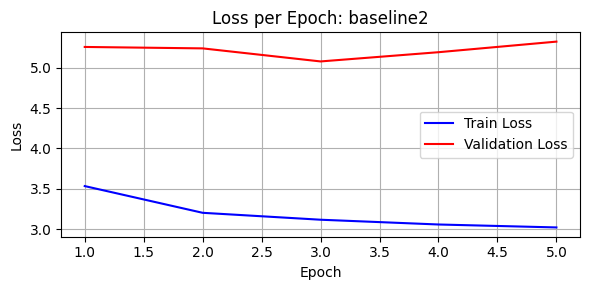


========== BEST MODEL SUMMARY (baseline2) ==========
Epoch:         3
Train Loss:    3.1154
Val Loss:      5.0793
Parameters:    8,830,585

Running test on BEST model...
Batch 1/17 | Loss: 5.1157
Batch 2/17 | Loss: 5.1077
Batch 3/17 | Loss: 4.9392
Batch 4/17 | Loss: 5.1756
Batch 5/17 | Loss: 4.9780
Batch 6/17 | Loss: 5.0086
Batch 7/17 | Loss: 4.9901
Batch 8/17 | Loss: 5.0702
Batch 9/17 | Loss: 4.9998
Batch 10/17 | Loss: 4.9855
Batch 11/17 | Loss: 5.2585
Batch 12/17 | Loss: 5.1476
Batch 13/17 | Loss: 5.1722
Batch 14/17 | Loss: 4.9799
Batch 15/17 | Loss: 5.1630
Batch 16/17 | Loss: 5.1312
Batch 17/17 | Loss: 5.2455


Evaluating Metrics: 100%|██████████| 17/17 [01:50<00:00,  6.53s/it]


Test Loss      : 5.0853
BLEU-4 Score   : 0.1571
METEOR Score   : 0.3015
BERTScore (F1) : 0.8626

--- BEST MODEL TEST RESULTS ---
Test Loss    : 5.0853
BLEU-4 Score : 0.1571
METEOR Score : 0.3015
BERTScore-F1 : 0.8626
--------------------------------------------------

========== FINAL MODEL SUMMARY (baseline2) ==========
Epoch:         5
Train Loss:    3.0198
Val Loss:      5.3251
Parameters:    8,830,585

Running test on FINAL model...
Batch 1/17 | Loss: 5.3738
Batch 2/17 | Loss: 5.2342
Batch 3/17 | Loss: 5.1798
Batch 4/17 | Loss: 5.3978
Batch 5/17 | Loss: 5.2976
Batch 6/17 | Loss: 5.1802
Batch 7/17 | Loss: 5.2732
Batch 8/17 | Loss: 5.3888
Batch 9/17 | Loss: 5.2841
Batch 10/17 | Loss: 5.1832
Batch 11/17 | Loss: 5.4683
Batch 12/17 | Loss: 5.3714
Batch 13/17 | Loss: 5.2898
Batch 14/17 | Loss: 5.1669
Batch 15/17 | Loss: 5.4192
Batch 16/17 | Loss: 5.4387
Batch 17/17 | Loss: 5.4468


Evaluating Metrics: 100%|██████████| 17/17 [01:49<00:00,  6.44s/it]


Test Loss      : 5.3164
BLEU-4 Score   : 0.1730
METEOR Score   : 0.3345
BERTScore (F1) : 0.8756

--- FINAL MODEL TEST RESULTS ---
Test Loss    : 5.3164
BLEU-4 Score : 0.1730
METEOR Score : 0.3345
BERTScore-F1 : 0.8756
--------------------------------------------------


In [40]:
for model_type, base_config in experiment_configs.items():
    print(f"\n================== 🔧 Training & Evaluating: {model_type} ==================")

    # ✅ config 복사 및 설정
    config = base_config.copy()

    # main 실행
    model, encoder, decoder, _, save_model_path, save_history_path, test_loader, recipe_vocab, ingredient_vocab = main(
        model_type, config, train_df, dev_df, test_df
    )

    # ✅ config에 필요한 정보 추가
    config["input_dim"] = len(ingredient_vocab)
    config["output_dim"] = len(recipe_vocab)
    config["recipe_vocab"] = recipe_vocab

    if not os.path.exists(save_model_path) or not os.path.exists(save_history_path):
        print(f"⚠️ Checkpoint for {model_type} not found. Skipping evaluation.\n")
        continue

    criterion = nn.CrossEntropyLoss(ignore_index=recipe_vocab['<pad>'])

    summarize_and_test_model(
        model_type=model_type,
        config=config,
        ingredient_vocab=ingredient_vocab,
        recipe_vocab=recipe_vocab,
        test_loader=test_loader,
        criterion=criterion
    )


# Plot for all model

In [41]:
# # 여러 모델들의 히스토리를 불러온 후
# baseline1_history = torch.load("results/baseline1_history.pt")["loss_history"]
# baseline2_history = torch.load("results/baseline2_history.pt")["loss_history"]
# mild1_history = torch.load("results/mild_extension1_history.pt")["loss_history"]

# plot_loss_iter(
#     baseline1=baseline1_history,
#     baseline2=baseline2_history,
#     mild_extension1=mild1_history
# )


# Generator

In [42]:
## old version ##
def generate_recipes(ingredient_list, ingredient_vocab, recipe_vocab, max_len=30, is_raw_string=False, **models):

    # Tokenizer 적용 여부
    if is_raw_string:
        tokens = tokenizer_ingredient(str(ingredient_list))
    else:
        tokens = ingredient_list

    # index로 변환
    tokens_ids = [ ingredient_vocab[token] if token in ingredient_vocab else ingredient_vocab['<unk>'] for token in tokens]
    src_tensor = torch.tensor(tokens_ids, dtype=torch.long, device=DEVICE).unsqueeze(0)

    print("Ingredient :",', '.join(tokens))
    for name, model in models.items():
        model.eval()
        with torch.no_grad():
            generated = model(src_tensor, target=None, teacher_forcing_ratio=0.0, max_len=max_len)
            pred_ids = generated[0].tolist()

            # <eos> 기준으로 자르기
            if recipe_vocab['<eos>'] in pred_ids:
                pred_ids = pred_ids[:pred_ids.index(recipe_vocab['<eos>'])]

            pred_tokens = [recipe_vocab.get_itos()[idx] for idx in pred_ids]
            print(f"{name}: {' '.join(pred_tokens[:30])}")
    print("-" * 100)

    

In [43]:
## old version ##
model = Seq2Seq(encoder, decoder, DEVICE, use_attention=config["USE_ATTENTION"]).to(DEVICE)
checkpoint = torch.load(save_model_path, map_location=DEVICE)
checkpoint2 = torch.load(save_history_path, map_location=DEVICE)
model.load_state_dict(checkpoint["model_state_dict"])

models = {
    "baseline1": load_baseline1,
    # "baseline2": load_baseline2
}

# # Sample 1: 전처리된 리스트
sample1_raw = "sugar, lemon juice,  water,  orange juice, strawberries, icecream"
sample1 = sample1_raw.split(", ")
generate_recipes(sample1, ingredient_vocab, recipe_vocab, is_raw_string=False, **models)

# Sample2 : 
sample2_raw ="8 oz philadelphia cream cheese, 14 oz can sweetened condensed milk, 1 ts vanilla, 1/3 c  lemon juice, 48 oz canned cherries, 8 inch graham cracker,  pie crusts"
sample2 = sample2_raw.split(", ")
generate_recipes(sample2, ingredient_vocab, recipe_vocab, is_raw_string=True, **models)

TypeError: Seq2Seq.__init__() missing 1 required positional argument: 'recipe_vocab'

In [ ]:
def load_trained_model_with_vocab(model_type: str, config: dict,
                                  train_df, dev_df, test_df):
    """
    모델 + vocab + tokenizer 세트 로드
    """
    model, encoder, decoder, _, save_model_path, _, test_loader, recipe_vocab = main(
        model_type, config, train_df, dev_df, test_df
    )
    checkpoint = torch.load(save_model_path, map_location=DEVICE)
    model.load_state_dict(checkpoint["model_state_dict"])
    
    # tokenizer, vocab도 함께 반환
    _, _, ingredient_vocab, recipe_vocab, tokenizer_ingredient, _ = load_or_tokenize_data(model_type, train_df)

    return {
        "model": model,
        "ingredient_vocab": ingredient_vocab,
        "recipe_vocab": recipe_vocab,
        "tokenizer_ingredient": tokenizer_ingredient
    }

def generate_recipes(ingredient_list, max_len=30, is_raw_string=False, **model_bundle_dict):
    for name, bundle in model_bundle_dict.items():
        model = bundle["model"]
        ingredient_vocab = bundle["ingredient_vocab"]
        recipe_vocab = bundle["recipe_vocab"]
        tokenizer_ingredient = bundle["tokenizer_ingredient"]

        # Tokenize
        if is_raw_string:
            tokens = tokenizer_ingredient(str(ingredient_list))
        else:
            tokens = ingredient_list

        # Index 변환
        token_ids = [ingredient_vocab[token] if token in ingredient_vocab else ingredient_vocab['<unk>'] for token in tokens]
        src_tensor = torch.tensor(token_ids, dtype=torch.long, device=DEVICE).unsqueeze(0)

        print(f"Ingredient ({name}):", ', '.join(tokens))
        model.eval()
        with torch.no_grad():
            generated = model(src_tensor, target=None, teacher_forcing_ratio=0.0, max_len=max_len)
            pred_ids = generated[0].tolist()
            if recipe_vocab['<eos>'] in pred_ids:
                pred_ids = pred_ids[:pred_ids.index(recipe_vocab['<eos>'])]
            pred_tokens = [recipe_vocab.get_itos()[idx] for idx in pred_ids]
            print(f"{name}: {' '.join(pred_tokens[:30])}")
    print("-" * 100)


In [ ]:
models = {"baseline1"}
for model_type, config in experiment_configs.items():
    if not config["new_model_train"]:
        continue
    models[model_type] = load_trained_model_with_vocab(model_type, config, train_df, dev_df, test_df)

sample1_raw = "sugar, lemon juice,  water,  orange juice, strawberries, icecream"
sample2_raw ="8 oz philadelphia cream cheese, 14 oz can sweetened condensed milk, 1 ts vanilla, 1/3 c  lemon juice, 48 oz canned cherries, 8 inch graham cracker,  pie crusts"
generate_recipes(sample1_raw, is_raw_string=True, **models)
